In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt

# Load the Dataset
df = pd.read_csv("C:/Users/Varun/OneDrive/Desktop/DATASET/merged_cleaned_data.csv",parse_dates=['SETTLEMENTDATE'])

# Feature Engineering
# Ensure datetime conversion
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'], errors='coerce')

# Create lagged price
df['lagged_RRP'] = df['RRP'].shift(1).bfill()

# Calculate percentage price change
df['price_change_pct'] = df['RRP'].pct_change().fillna(0) * 100

# Calculate demand forecast error
df['demand_error'] = df['TOTALDEMAND'] - df['DEMANDFORECAST']

# Extract temporal features
df['hour_of_day'] = df['SETTLEMENTDATE'].dt.hour
df['day_of_week'] = df['SETTLEMENTDATE'].dt.dayofweek

# Define Selected Features
features = [
    'RRP', 'lagged_RRP', 'price_change_pct', 'demand_error',
    'TOTALDEMAND', 'AVAILABLEGENERATION', 'DISPATCHABLEGENERATION',
    'TRADING_RRP', 'TEMPERATURE', 'SOLAR_RADIATION', 'RAINFALL',
    'hour_of_day', 'day_of_week'
]


In [2]:
df

,SETTLEMENTDATE,REGIONID,RRP,MARKETSUSPENDEDFLAG,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,...,TRADING_RRP,DATE,RAINFALL,TEMPERATURE,SOLAR_RADIATION,lagged_RRP,price_change_pct,demand_error,hour_of_day,day_of_week
0,2022-01-01 00:05:00,QLD1,118.73008,0.0,5.00,2.29,0.75,19.94,0.18,0.90,...,118.73,2022-01-01,NaN,26.6,10.1,118.73008,0.000000,5994.84561,0,5
1,2022-01-01 00:10:00,QLD1,119.10000,0.0,5.00,2.29,0.75,19.94,0.18,0.90,...,119.10,2022-01-01,NaN,26.6,10.1,118.73008,0.311564,6040.45600,0,5
2,2022-01-01 00:15:00,QLD1,118.73008,0.0,5.00,1.98,0.75,19.94,0.18,0.90,...,118.73,2022-01-01,NaN,26.6,10.1,119.10000,-0.310596,6025.94813,0,5
3,2022-01-01 00:20:00,QLD1,109.20000,0.0,5.00,2.29,0.75,19.94,0.18,0.90,...,109.20,2022-01-01,NaN,26.6,10.1,118.73008,-8.026677,5942.65281,0,5
4,2022-01-01 00:25:00,QLD1,117.61542,0.0,5.00,2.29,0.75,19.94,0.18,0.90,...,117.62,2022-01-01,NaN,26.6,10.1,109.20000,7.706429,5924.75816,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220660,2023-12-31 23:40:00,QLD1,85.55000,0.0,0.39,0.39,0.39,1.00,0.01,0.07,...,85.55,2023-12-31,5.8,30.4,28.3,85.55000,0.000000,6438.64000,23,6
220661,2023-12-31 23:45:00,QLD1,85.55000,0.0,0.39,0.39,0.39,1.00,0.03,0.17,...,85.55,2023-12-31,5.8,30.4,28.3,85.55000,0.000000,6391.79000,23,6
220662,2023-12-31 23:50:00,QLD1,85.75000,0.0,0.39,0.39,0.39,2.64,0.01,0.08,...,85.75,2023-12-31,5.8,30.4,28.3,85.55000,0.233781,6399.35000,23,6
220663,2023-12-31 23:55:00,QLD1,85.55000,0.0,0.39,0.39,0.38,0.91,0.03,0.15,...,85.55,2023-12-31,5.8,30.4,28.3,85.75000,-0.233236,6343.06000,23,6


In [3]:
df.columns

Index(['SETTLEMENTDATE', 'REGIONID', 'RRP', 'MARKETSUSPENDEDFLAG',
       'RAISE6SECRRP', 'RAISE60SECRRP', 'RAISE5MINRRP', 'RAISEREGRRP',
       'LOWER6SECRRP', 'LOWER60SECRRP', 'LOWER5MINRRP', 'LOWERREGRRP',
       'TOTALDEMAND', 'DEMANDFORECAST', 'AVAILABLEGENERATION',
       'DISPATCHABLEGENERATION', 'NETINTERCHANGE', 'TRADING_RRP', 'DATE',
       'RAINFALL', 'TEMPERATURE', 'SOLAR_RADIATION', 'lagged_RRP',
       'price_change_pct', 'demand_error', 'hour_of_day', 'day_of_week'],
      dtype='object')

In [4]:
# Drop NaNs, handle inf values, and scale the features
X = df[features].replace([np.inf, -np.inf], np.nan).dropna()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
# ----------------------------------
# Isolation Forest Anomaly Detection
# ----------------------------------
# Train Isolation Forest on full scaled feature set
iso_model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df_iso = X.copy()
df_iso['iso_anomaly'] = iso_model.fit_predict(X_scaled)
# Convert output: -1 = anomaly → 1, 1 = normal → 0
df_iso['iso_anomaly'] = df_iso['iso_anomaly'].map({1: 0, -1: 1})

In [9]:
df_iso

,RRP,lagged_RRP,price_change_pct,demand_error,TOTALDEMAND,AVAILABLEGENERATION,DISPATCHABLEGENERATION,TRADING_RRP,TEMPERATURE,SOLAR_RADIATION,RAINFALL,hour_of_day,day_of_week,iso_anomaly
575,91.20000,91.20000,0.000000,5963.68545,5931.35,9525.71501,5733.61,91.20,30.2,23.4,0.0,0,0,0
576,109.20000,91.20000,19.736842,5963.01764,5939.19,9529.07401,5622.78,109.20,30.2,23.4,0.0,0,0,0
577,109.09998,109.20000,-0.091593,5902.69941,5875.05,9523.92301,5528.22,109.10,30.2,23.4,0.0,0,0,0
578,107.42242,109.09998,-1.537635,5872.74354,5851.37,9524.36201,5500.82,107.42,30.2,23.4,0.0,0,0,0
579,109.10000,107.42242,1.561667,5888.37908,5853.82,9533.37801,5494.25,109.10,30.2,23.4,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220659,85.55000,60.60896,41.150747,6466.49000,6441.49,9324.73916,5912.86,85.55,30.4,28.3,5.8,23,6,0
220660,85.55000,85.55000,0.000000,6438.64000,6384.64,9315.29446,5857.84,85.55,30.4,28.3,5.8,23,6,0
220661,85.55000,85.55000,0.000000,6391.79000,6374.79,9115.39488,5848.00,85.55,30.4,28.3,5.8,23,6,0
220662,85.75000,85.55000,0.233781,6399.35000,6386.35,9126.19154,5858.87,85.75,30.4,28.3,5.8,23,6,0


In [10]:
df_iso.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217122 entries, 575 to 220663
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   RRP                     217122 non-null  float64
 1   lagged_RRP              217122 non-null  float64
 2   price_change_pct        217122 non-null  float64
 3   demand_error            217122 non-null  float64
 4   TOTALDEMAND             217122 non-null  float64
 5   AVAILABLEGENERATION     217122 non-null  float64
 6   DISPATCHABLEGENERATION  217122 non-null  float64
 7   TRADING_RRP             217122 non-null  float64
 8   TEMPERATURE             217122 non-null  float64
 9   SOLAR_RADIATION         217122 non-null  float64
 10  RAINFALL                217122 non-null  float64
 11  hour_of_day             217122 non-null  int32  
 12  day_of_week             217122 non-null  int32  
 13  iso_anomaly             217122 non-null  int64  
dtypes: float64(11), int32(2

In [11]:
# Count and print number of anomalies detected by Isolation Forest
num_iso_anomalies = df_iso['iso_anomaly'].sum()/len(df_iso)
print(f"Number of anomalies detected by Isolation Forest: {num_iso_anomalies}")

Number of anomalies detected by Isolation Forest: 0.0200025791951069


In [12]:
# Create Sliding Windows for LSTM
window_size = 96
X_seq = []
for i in range(len(X_scaled) - window_size):
    X_seq.append(X_scaled[i:i+window_size])
X_seq = np.array(X_seq)

# Build LSTM Autoencoder Model
input_dim = X_seq.shape[2]
inputs = Input(shape=(window_size, input_dim))
encoded = LSTM(64, return_sequences=False)(inputs)
bottleneck = RepeatVector(window_size)(encoded)
decoded = LSTM(64, return_sequences=True)(bottleneck)
outputs = TimeDistributed(Dense(input_dim))(decoded)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

# Train the LSTM Autoencoder
model.fit(X_seq, X_seq, epochs=30, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 329s 106ms/step - loss: 0.0088 - val_loss: 0.0013
Epoch 2/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 301s 99ms/step - loss: 0.0010 - val_loss: 8.6527e-04
Epoch 3/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 249s 82ms/step - loss: 8.4124e-04 - val_loss: 8.1116e-04
Epoch 4/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 265s 87ms/step - loss: 6.1090e-04 - val_loss: 5.9193e-04
Epoch 5/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 267s 87ms/step - loss: 5.2574e-04 - val_loss: 5.4852e-04
Epoch 6/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 271s 89ms/step - loss: 4.6558e-04 - val_loss: 4.5584e-04
Epoch 7/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 255s 84ms/step - loss: 4.3536e-04 - val_loss: 3.9063e-04
Epoch 8/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 257s 84ms/step - loss: 4.0428e-04 - val_loss: 3.8401e-04
Epoch 9/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 253s 83ms/step - loss: 3.6473e-04 - val_loss: 3.7030e-04
Epoch 10/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 263s 86ms/step - loss: 3.5127e-04 - val_loss: 4.2261e-04
Epoch 11/30
3052/305

In [13]:
# Reconstruct and Compute Reconstruction Error
X_pred = model.predict(X_seq)
reconstruction_errors = np.mean(np.square(X_seq - X_pred), axis=(1, 2))

# Set Threshold and Flag Anomalies
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

# Attach LSTM Anomaly Labels to Data
anomaly_df = X.iloc[window_size:].copy()
anomaly_df['reconstruction_error'] = reconstruction_errors
anomaly_df['lstm_anomaly'] = anomalies.astype(int)

# Combine Both Anomaly Flags
anomaly_df['iso_anomaly'] = df_iso.iloc[window_size:]['iso_anomaly'].values

6783/6783 ━━━━━━━━━━━━━━━━━━━━ 124s 18ms/step


In [14]:
anomaly_df.tail(10)

,RRP,lagged_RRP,price_change_pct,demand_error,TOTALDEMAND,AVAILABLEGENERATION,DISPATCHABLEGENERATION,TRADING_RRP,TEMPERATURE,SOLAR_RADIATION,RAINFALL,hour_of_day,day_of_week,reconstruction_error,lstm_anomaly,iso_anomaly
220654,65.47628,61.87869,5.813940,6616.48,6589.48,9570.58009,6127.72,65.48,30.4,28.3,5.8,23,6,0.000115,0,0
220655,64.98145,65.47628,-0.755739,6574.99,6575.99,9579.74810,6135.83,64.98,30.4,28.3,5.8,23,6,0.000110,0,0
220656,65.45639,64.98145,0.730886,6613.07,6601.07,9575.39208,6132.63,65.46,30.4,28.3,5.8,23,6,0.000108,0,0
220657,65.35098,65.45639,-0.161039,6582.44,6555.44,9568.80508,6125.14,65.35,30.4,28.3,5.8,23,6,0.000107,0,0
220658,60.60896,65.35098,-7.256234,6510.98,6492.98,9581.54185,6187.67,60.61,30.4,28.3,5.8,23,6,0.000105,0,0
220659,85.55000,60.60896,41.150747,6466.49,6441.49,9324.73916,5912.86,85.55,30.4,28.3,5.8,23,6,0.000105,0,0
220660,85.55000,85.55000,0.000000,6438.64,6384.64,9315.29446,5857.84,85.55,30.4,28.3,5.8,23,6,0.000105,0,0
220661,85.55000,85.55000,0.000000,6391.79,6374.79,9115.39488,5848.00,85.55,30.4,28.3,5.8,23,6,0.000106,0,0
220662,85.75000,85.55000,0.233781,6399.35,6386.35,9126.19154,5858.87,85.75,30.4,28.3,5.8,23,6,0.000110,0,0
220663,85.55000,85.75000,-0.233236,6343.06,6296.06,9388.81190,5767.10,85.55,30.4,28.3,5.8,23,6,0.000114,0,0


In [15]:
# Print anomaly percentages from LSTM and Isolation Forest
lstm_count = anomaly_df['lstm_anomaly'].sum()
lstm_percent = lstm_count / len(anomaly_df) * 100

iso_count = anomaly_df['iso_anomaly'].sum()
iso_percent = iso_count / len(anomaly_df) * 100

print(f"LSTM Anomalies: {lstm_count} ({lstm_percent:.2f}%)")
print(f"Isolation Forest Anomalies: {iso_count} ({iso_percent:.2f}%)")


LSTM Anomalies: 10852 (5.00%)
Isolation Forest Anomalies: 4343 (2.00%)


In [16]:
# Compare agreement between LSTM and Isolation Forest
anomaly_df['both_agree'] = (anomaly_df['lstm_anomaly'] == 1) & (anomaly_df['iso_anomaly'] == 1)
both_agree_count = anomaly_df['both_agree'].sum()
print(f"Both models agree on {both_agree_count} anomalies ({(both_agree_count/len(anomaly_df))*100:.2f}%)")


Both models agree on 1563 anomalies (0.72%)


In [17]:
# Save final combined anomaly output for future use
anomaly_df.to_csv("anomaly_detected_combined.csv", index=False)

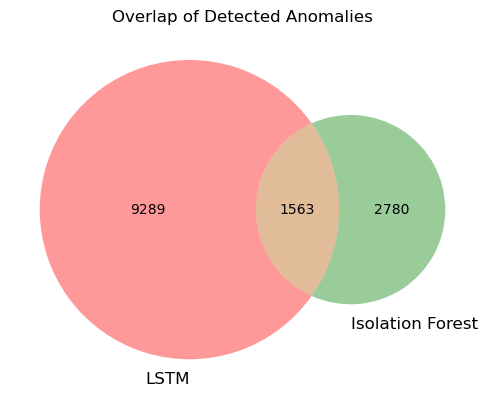

In [18]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6))
venn2(subsets = (
    ((anomaly_df['lstm_anomaly'] == 1) & (anomaly_df['iso_anomaly'] == 0)).sum(),
    ((anomaly_df['iso_anomaly'] == 1) & (anomaly_df['lstm_anomaly'] == 0)).sum(),
    ((anomaly_df['lstm_anomaly'] == 1) & (anomaly_df['iso_anomaly'] == 1)).sum()
), set_labels=('LSTM', 'Isolation Forest'))
plt.title("Overlap of Detected Anomalies")
plt.show()


In [19]:
# Top anomalies by LSTM reconstruction error
top_anomalies = anomaly_df.sort_values(by='reconstruction_error', ascending=False).head(10)
print(top_anomalies[['RRP', 'reconstruction_error', 'lstm_anomaly', 'iso_anomaly']])


            RRP  reconstruction_error  lstm_anomaly  iso_anomaly
9237   70.81522              0.030475             1            0
9236   70.81522              0.030418             1            1
9238 -999.99417              0.030147             1            0
9235 -999.99171              0.030082             1            1
9239 -999.99417              0.029818             1            1
9234 -999.99171              0.029789             1            0
9233   86.04854              0.029560             1            0
9240  300.10000              0.029533             1            1
9232   86.04854              0.029168             1            0
9241  300.10000              0.029159             1            0


In [20]:
# Check for RRP values equal to -999.99 in the original dataset
invalid_rrp_rows = df[df['RRP'] == -999.99]

# Display results
print(f"Number of rows with RRP = -999.99: {len(invalid_rrp_rows)}")
invalid_rrp_rows.head()


Number of rows with RRP = -999.99: 0


,SETTLEMENTDATE,REGIONID,RRP,MARKETSUSPENDEDFLAG,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,...,DEMANDFORECAST,AVAILABLEGENERATION,DISPATCHABLEGENERATION,NETINTERCHANGE,TRADING_RRP,DATE,RAINFALL,TEMPERATURE,SOLAR_RADIATION,month


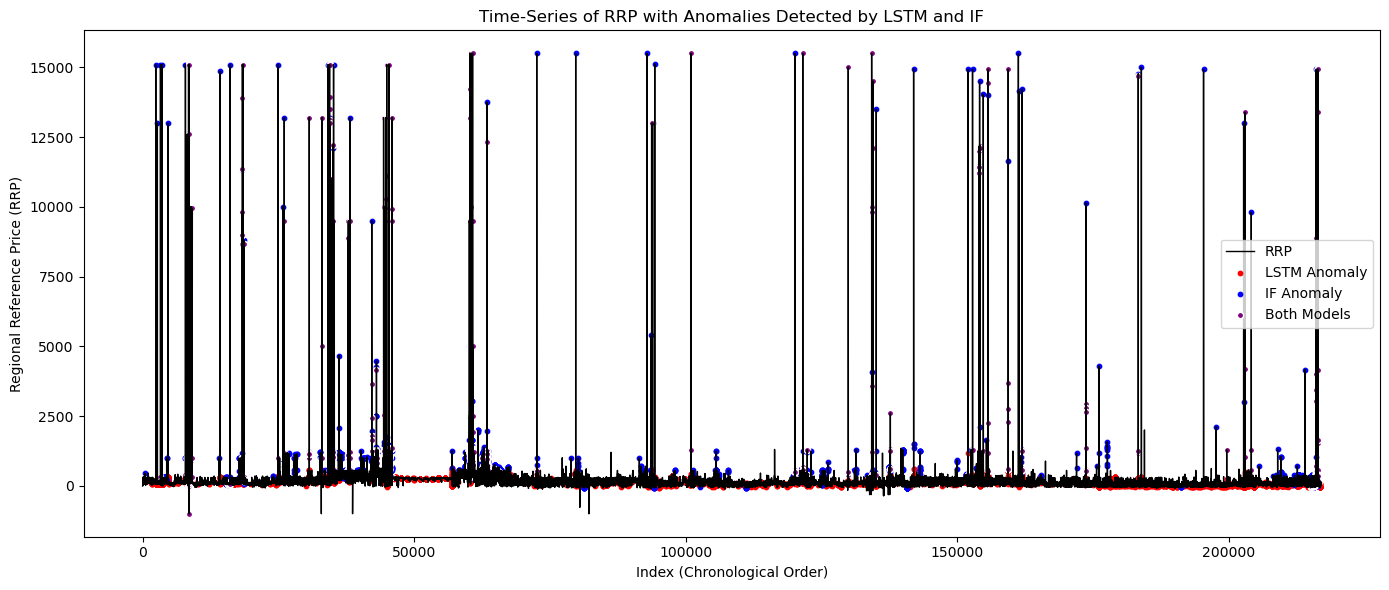

In [21]:
# Load the dataset
df = pd.read_csv("anomaly_detected_combined.csv")

# Create 'both_agree' column if not present
df['both_agree'] = (df['lstm_anomaly'] == 1) & (df['iso_anomaly'] == 1)

# Create index for plotting (since no timestamp column)
df['index'] = range(len(df))

# Plot RRP time-series
plt.figure(figsize=(14, 6))
plt.plot(df['index'], df['RRP'], label='RRP', color='black', linewidth=1)

# Overlay anomalies
plt.scatter(df[df['lstm_anomaly'] == 1]['index'], df[df['lstm_anomaly'] == 1]['RRP'],
            color='red', label='LSTM Anomaly', s=10)
plt.scatter(df[df['iso_anomaly'] == 1]['index'], df[df['iso_anomaly'] == 1]['RRP'],
            color='blue', label='IF Anomaly', s=10)
plt.scatter(df[df['both_agree'] == True]['index'], df[df['both_agree'] == True]['RRP'],
            color='purple', label='Both Models', s=20, edgecolor='white')

# Formatting
plt.title("Time-Series of RRP with Anomalies Detected by LSTM and IF")
plt.xlabel("Index (Chronological Order)")
plt.ylabel("Regional Reference Price (RRP)")
plt.legend()
plt.tight_layout()
plt.show()


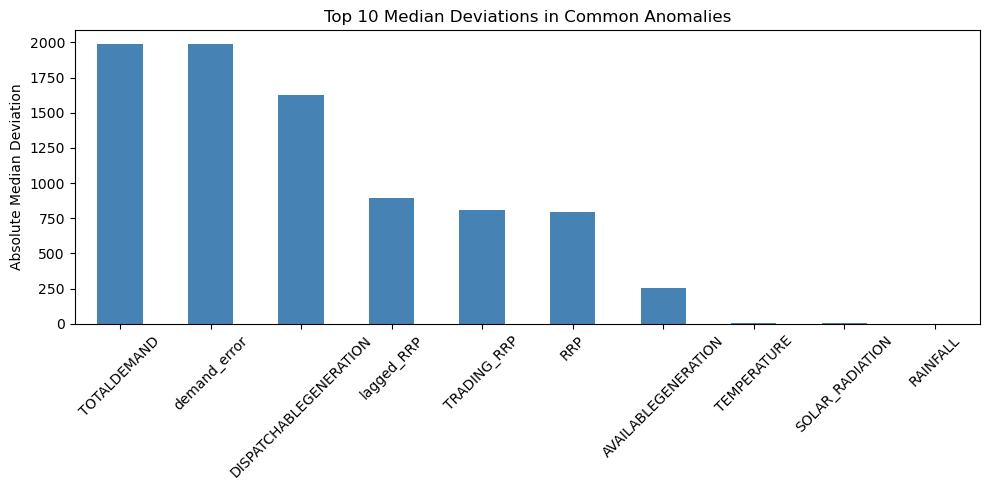

In [22]:
# Load your data
df = pd.read_csv("anomaly_detected_combined.csv")

# Confirm both_agree column exists
df['both_agree'] = (df['lstm_anomaly'] == 1) & (df['iso_anomaly'] == 1)

# Keep only original (unscaled) meaningful features
core_features = [
    'RRP', 'lagged_RRP', 'price_change_pct', 'demand_error', 'TOTALDEMAND',
    'AVAILABLEGENERATION', 'DISPATCHABLEGENERATION', 'TRADING_RRP',
    'TEMPERATURE', 'SOLAR_RADIATION', 'RAINFALL'
]

# Calculate median deviation
normal_median = df[df['both_agree'] == False][core_features].median()
anomaly_median = df[df['both_agree'] == True][core_features].median()
deviation = (anomaly_median - normal_median).abs().sort_values(ascending=False)

# Plot top 10
plt.figure(figsize=(10, 5))
deviation.head(10).plot(kind='bar', color='steelblue')
plt.title("Top 10 Median Deviations in Common Anomalies")
plt.ylabel("Absolute Median Deviation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top 10 High-Confidence Anomalies (LSTM + IF):
              RRP  reconstruction_error  TOTALDEMAND  TEMPERATURE  \
8552     70.81522              0.030418      9068.35         34.7   
8551   -999.99171              0.030082      9149.24         34.7   
8555   -999.99417              0.029818      9068.35         34.7   
8556    300.10000              0.029533      9086.19         34.7   
8547     77.07020              0.028984      9268.48         34.7   
8546     77.07020              0.028890      9268.48         34.7   
8545  15100.00000              0.028829      9268.48         34.7   
8544  15100.00000              0.028698      9268.48         34.7   
8543     11.00008              0.028667      9205.84         34.7   
8541  12594.00000              0.028637      9205.84         34.7   

      demand_error  
8552    9112.66738  
8551    9157.56813  
8555    9112.66738  
8556    9119.83648  
8547    9244.11867  
8546    9244.11867  
8545    9244.11867  
8544    9244.11867  
8543 

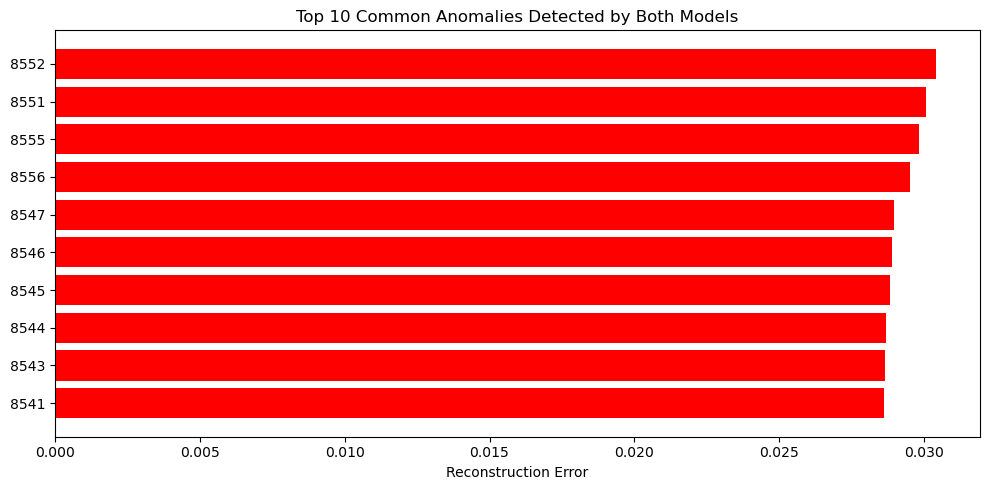

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your anomaly detection results (no date column to parse)
df = pd.read_csv("anomaly_detected_combined.csv")

# Create the both_agree column
df['both_agree'] = (df['lstm_anomaly'] == 1) & (df['iso_anomaly'] == 1)

# Filter where both models agree
common_anomalies = df[df['both_agree'] == True]

# Sort by reconstruction error and pick top 10
top_common = common_anomalies.sort_values(by='reconstruction_error', ascending=False).head(10)

# Display the top anomalies
print("Top 10 High-Confidence Anomalies (LSTM + IF):")
print(top_common[['RRP', 'reconstruction_error', 'TOTALDEMAND', 'TEMPERATURE', 'demand_error']])

# Visualize as a bar chart
plt.figure(figsize=(10, 5))
plt.barh(top_common.index.astype(str), top_common['reconstruction_error'], color='red')
plt.xlabel("Reconstruction Error")
plt.title("Top 10 Common Anomalies Detected by Both Models")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

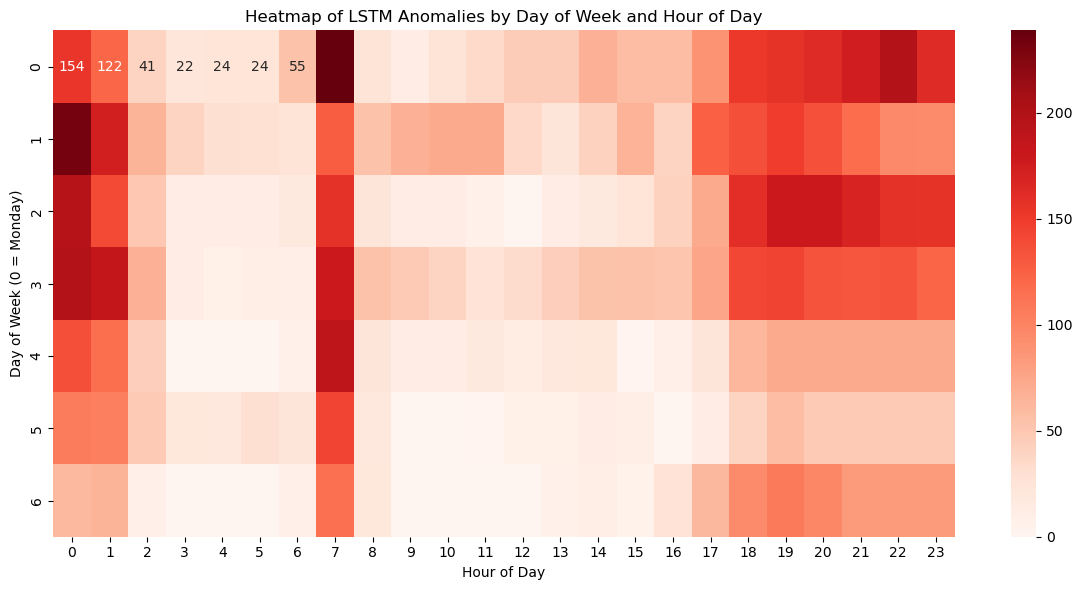

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load anomaly file
df = pd.read_csv("anomaly_detected_combined.csv")

# Create time-based features if not already present
df['hour_of_day'] = df.get('hour_of_day', pd.Series(range(len(df))) % 24)
df['day_of_week'] = df.get('day_of_week', pd.Series(range(len(df))) % 7)

# Create a pivot table showing count of LSTM anomalies by hour and day
heatmap_data = df[df['lstm_anomaly'] == 1].pivot_table(
    index='day_of_week',
    columns='hour_of_day',
    values='RRP',
    aggfunc='count',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt='d')
plt.title("Heatmap of LSTM Anomalies by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0 = Monday)")
plt.tight_layout()
plt.show()


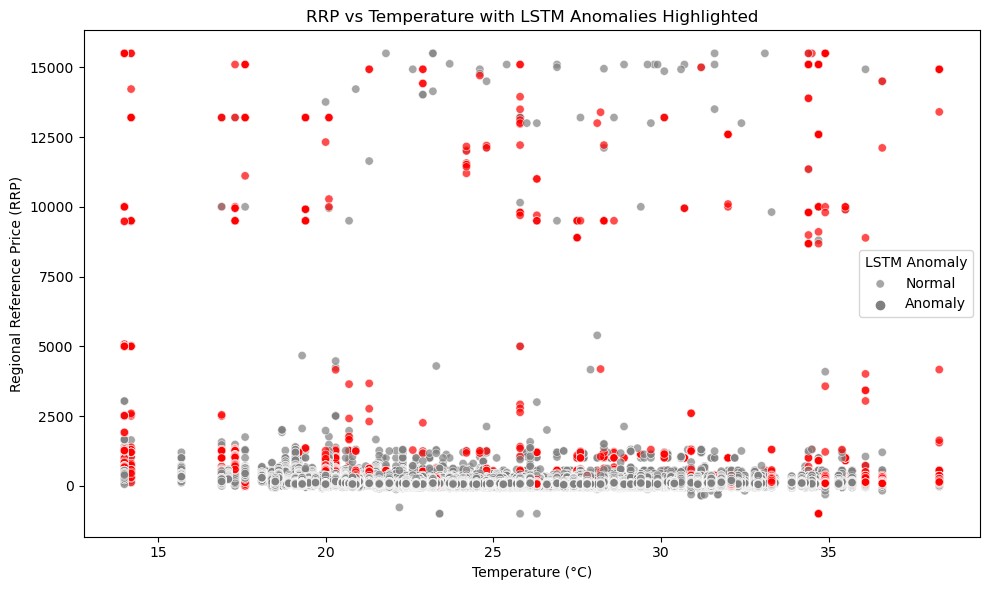

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("anomaly_detected_combined.csv")

# Scatter plot: RRP vs Temperature, colored by LSTM anomaly
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='TEMPERATURE', y='RRP', hue='lstm_anomaly',
                palette={0: 'gray', 1: 'red'}, alpha=0.7)

plt.title("RRP vs Temperature with LSTM Anomalies Highlighted")
plt.xlabel("Temperature (°C)")
plt.ylabel("Regional Reference Price (RRP)")
plt.legend(title="LSTM Anomaly", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.show()
